# Deep Vision Transformer Implementation

In [14]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd           
import numpy as np                        
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import os
import random
import tqdm
import cv2
import imghdr

import torch
import torchvision
from torchvision import transforms 
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SequentialSampler
from torchvision.transforms import functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from vit_pytorch.deepvit import DeepViT
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings(action='ignore')

# We are determining whether a person in the picture is happy or sad. 

### 1. Remove Wrong Format Images

In [15]:
data_dir = 'data'

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            if img is None:  # Check if image is loaded successfully
                print('Image not loaded properly {}'.format(image_path))
                os.remove(image_path)
                continue
            
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}: {}'.format(image_path, e))
            os.remove(image_path)

### 2. Import, Transform, and Send to Dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


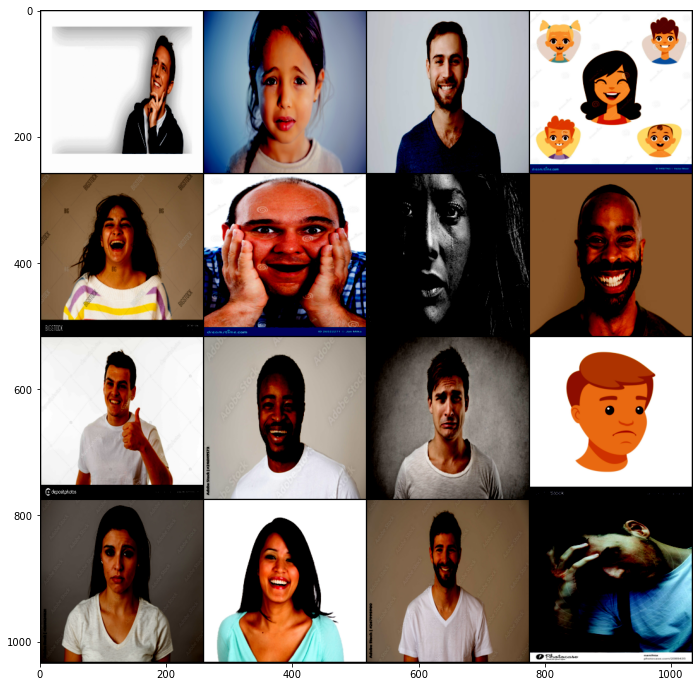

In [52]:
data_dir = 'data'

# We are determining whether a person in the picture is happy or sad. 

# Define the transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the images to a fixed size
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Create the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)    # Really important function here

# Define the sizes for each split
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

# Split the dataset
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Send to DataLoader
train_loader = DataLoader(dataset = train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(dataset = val_data, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=16, shuffle=True)

# Function to plot images
def show_images(images, labels):
    plt.figure(figsize=(12, 12))
    grid = make_grid(images, nrow=4)
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images, labels)

### 3. Check for GPU

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 4. Define and Train/Validate Model

In [ ]:
num_classes = 2 # Define number of labels

# Initialize the DeepViT model
model = DeepViT(
    image_size = 256,
    patch_size = 32,
    num_classes = num_classes,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = .2
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() if num_classes > 1 else nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
epochs = 65
model.to(device)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm.tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

### 5. Validate on Test Holdout

In [46]:
def validate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_accuracy = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for data, label in tqdm.tqdm(test_loader):
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            acc = (output.argmax(dim=1) == label).float().mean()
            total_accuracy += acc.item()
            total_loss += loss.item()
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader)
    
    print(f"Validation - loss: {avg_loss:.4f} - acc: {avg_accuracy:.4f}")

validate(model, test_loader, criterion, device)

100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

Validation - loss: 1.0544 - acc: 0.8563
